In [2]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch.nn as nn

from PIL import Image
from vision_transformers.models import vit
from tools.utils.transforms import get_valid_transform
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class_names = [
    'parasitized',
    'uninfected'
]

In [5]:
model = vit.vit_ti_p16_224(num_classes=len(class_names), pretrained=False).eval()
ckpt = torch.load('runs/training/vit_ti_5e_128b/best_model.pth')
model.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )
])

## Inference 

In [7]:
def infer(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    plt.figure(figsize=(6, 3))
    plt.imshow(image)
    plt.axis('off')
    input_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)
    
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    probabilities = probabilities.numpy()
    category = class_names[np.argmax(probabilities)]
    plt.text(x=10, y=20, s=category, fontsize='large', color='red')
    plt.show()

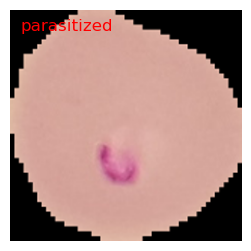

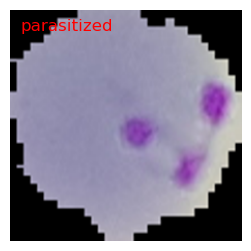

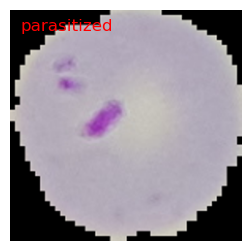

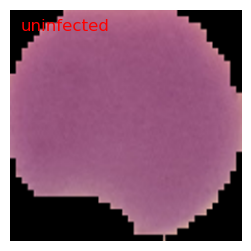

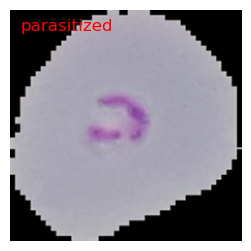

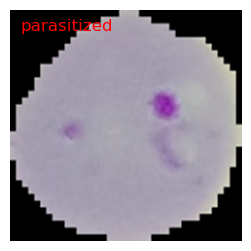

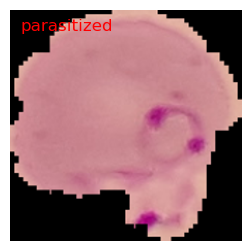

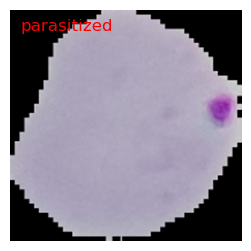

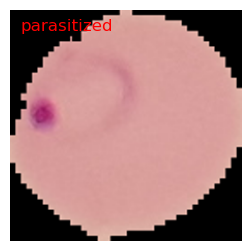

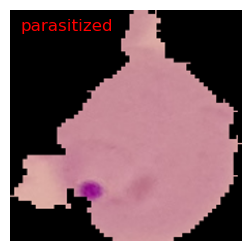

In [8]:
image_paths = glob.glob('/lustre/fs0/bsc4892/share/Malaria_dataset/test/parasitized/*')
for i, image_path in enumerate(image_paths):
    if i == 10:
        break
    infer(image_path)

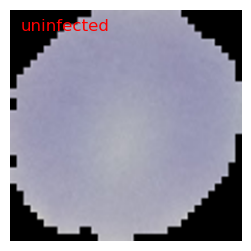

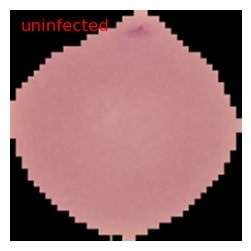

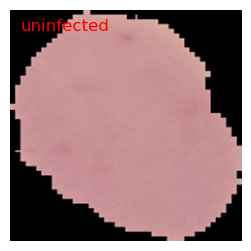

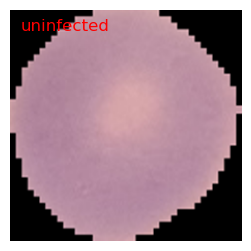

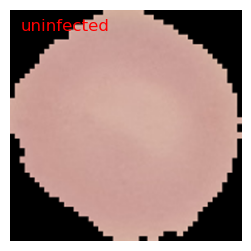

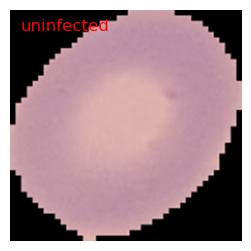

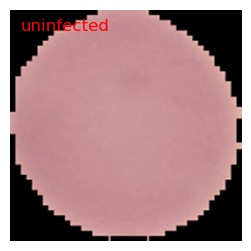

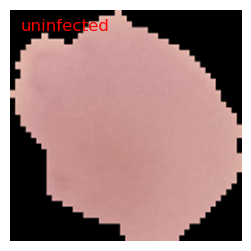

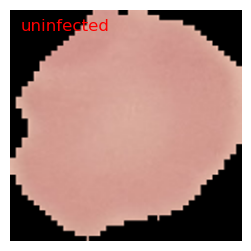

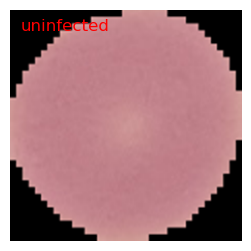

In [9]:
image_paths = glob.glob('/lustre/fs0/bsc4892/share/Malaria_dataset/test/uninfected/*')
for i, image_path in enumerate(image_paths):
    if i == 10:
        break
    infer(image_path)

## Evaluation

In [10]:
# Create test dataset.
dataset_test = datasets.ImageFolder(
    '/lustre/fs0/bsc4892/share/Malaria_dataset/test', 
    transform=(get_valid_transform(224))
)

In [11]:
print(f"Number of test samples: {len(dataset_test)}")

Number of test samples: 7143


In [12]:
test_dataloader = DataLoader(
        dataset_test,
        batch_size=128,
        num_workers=4,
        shuffle=False
    )

In [13]:
# Loss function.
criterion = nn.CrossEntropyLoss()

In [14]:
def validate(model, testloader, criterion):
    model.eval().to(device)
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [15]:
test_loss, test_acc = validate(model, test_dataloader, criterion)

100%|██████████| 56/56 [00:09<00:00,  5.71it/s]


In [16]:
print(f"Test loss: {test_loss:.3f}, test accuracy: {test_acc:.3f}")

Test loss: 0.082, test accuracy: 96.934


## Attention Maps

In [17]:
model = model.cpu()

In [18]:
image = Image.open('/lustre/fs0/bsc4892/share/Malaria_dataset/test/parasitized/C100P61ThinF_IMG_20150918_144823_cell_161.png')
image = image.resize((224, 224))
input_tensor = transform(image).unsqueeze(0)

In [19]:
# Patch embedding.
patches = model.patches.patch(input_tensor)
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Patch embedding shape: {patches.shape}")

Input tensor shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 192, 14, 14])


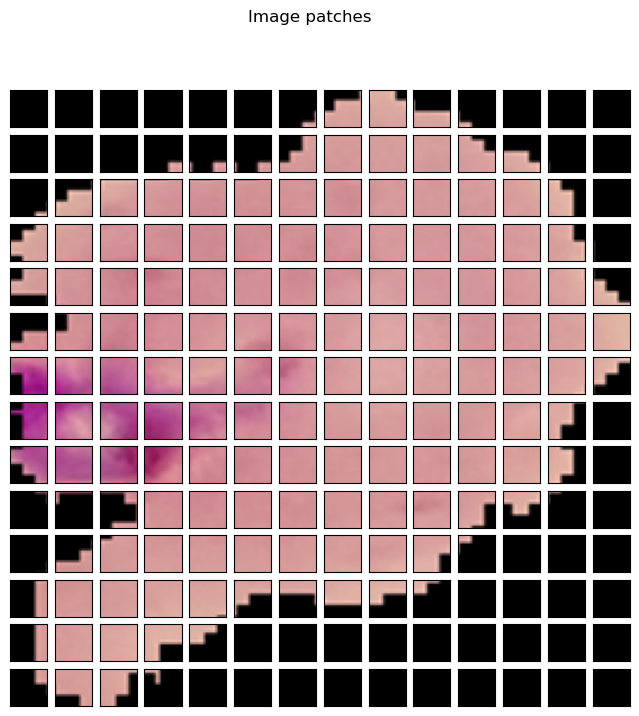

In [20]:
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Image patches", fontsize=12)
img = np.asarray(image)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

In [21]:
pos_embed = model.pos_embedding
print(pos_embed.shape)

torch.Size([1, 197, 192])


In [22]:
patch_input = patches.view(1, 192, 196).permute(0, 2, 1)
print(patch_input.shape)

torch.Size([1, 196, 192])


In [23]:
transformer_input = torch.cat((model.cls_token, patch_input), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

Transformer input:  torch.Size([1, 197, 192])


In [24]:
transformer_input_qkv = model.transformer.layers[0][0].fn.qkv(transformer_input)[0]
print(transformer_input_qkv.shape)

torch.Size([197, 576])


In [25]:
qkv = transformer_input_qkv.reshape(197, 3, 12, 16)
print("Reshaped qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)
k = qkv[:, 1].permute(1, 0, 2)
kT = k.permute(0, 2, 1)
print("K transposed: ", kT.shape)

Reshaped qkv :  torch.Size([197, 3, 12, 16])
K transposed:  torch.Size([12, 16, 197])


Attention matrix:  torch.Size([12, 197, 197])


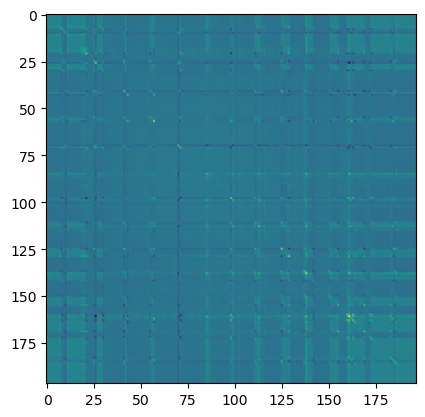

In [26]:
# Attention Matrix
attention_matrix = q @ kT
print("Attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

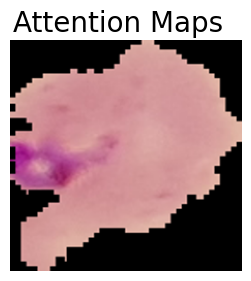

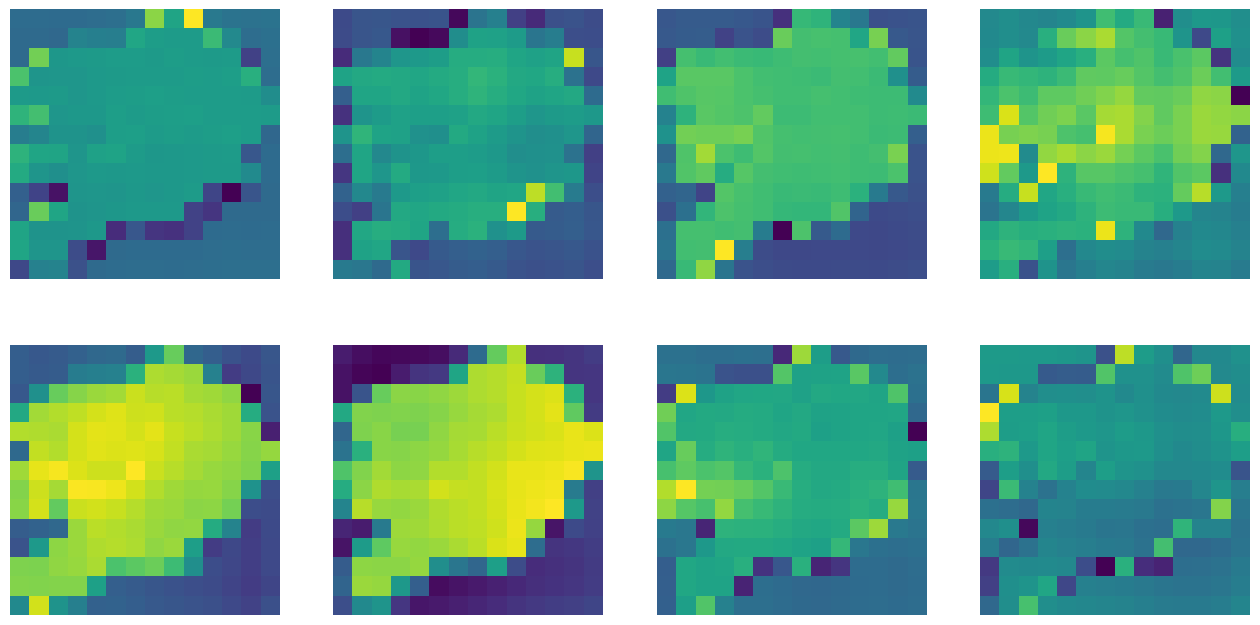

In [27]:
# Visualize attention matrix
fig = plt.figure(figsize=(6, 3))
fig.suptitle("Attention Maps", fontsize=20)
# fig.add_axes()
img = np.asarray(img)
ax1 = fig.add_subplot(1, 1, 1)
ax1.imshow(img)
ax1.axis('off')
fig = plt.figure(figsize=(16, 8))
for i in range(8):
    attn_heatmap = attention_matrix[i, 64, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax2 = fig.add_subplot(2, 4, i+1)
    ax2.imshow(attn_heatmap)
    ax2.axis('off')